# PCB Anomaly Detection
**Author : Advait Athreya**

## Step0. Loading and extracting data, Importing Libraries



In [2]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/Golden images/
  inflating: data/Golden images/golden_image_1.png  
  inflating: data/Golden images/golden_image_10.png  
  inflating: data/Golden images/golden_image_2.png  
  inflating: data/Golden images/golden_image_3.png  
  inflating: data/Golden images/golden_image_4.png  
  inflating: data/Golden images/golden_image_5.png  
  inflating: data/Golden images/golden_image_6.png  
  inflating: data/Golden images/golden_image_7.png  
  inflating: data/Golden images/golden_image_8.png  
  inflating: data/Golden images/golden_image_9.png  
   creating: data/pcb1_defect_highlighted/
  inflating: data/pcb1_defect_highlighted/image1_highlighted.png  
   creating: data/pcb1_defect_images/
  inflating: data/pcb1_defect_images/defect_image_1.png  
  inflating: data/pcb1_defect_images/defect_image_1_.png  
  inflating: data/pcb1_defect_images/defect_image_2_.png  
  inflating: data/pcb1_defect_images/defect_image_3_.png  
  inflating: data/pcb1_defect_im

In [3]:
import cv2
import numpy as np
import os
import glob
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

## Step1. Understanding the data

The data consists of  10 golden images as reference, and 3 folders of PCB1,PCB2, PCB3 having 6 images each. My initial step is to understand what this underlying data refers to and whether the copies are all different or similar.

Browsing through the folders,  We see that the PCB images do not differ by much. However, there could be slight differences, this is a 3000x 3000 resolution image.

Let's visualize a few images by overlaying one on top of the other. I visualize image1 of the golden images on the green channel, and select 2 images namely golden_image_2 and golden_image_10  on the blue channel. These are then overlaid on top of image1.

##Data Preprocessing :
Since all the images are in black or white, we write a simple method to binarize the images. A look at the CV2 docs shows that  Otsu's thresholding automatically finds the best threshold to binarize the image, so we use this than statically determining the threshold.

In [27]:
def binarize_image(image):
    """Convert grayscale image to binary using Otsu's thresholding.""" #https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    return binary_image

## Expand for visualized golden_images

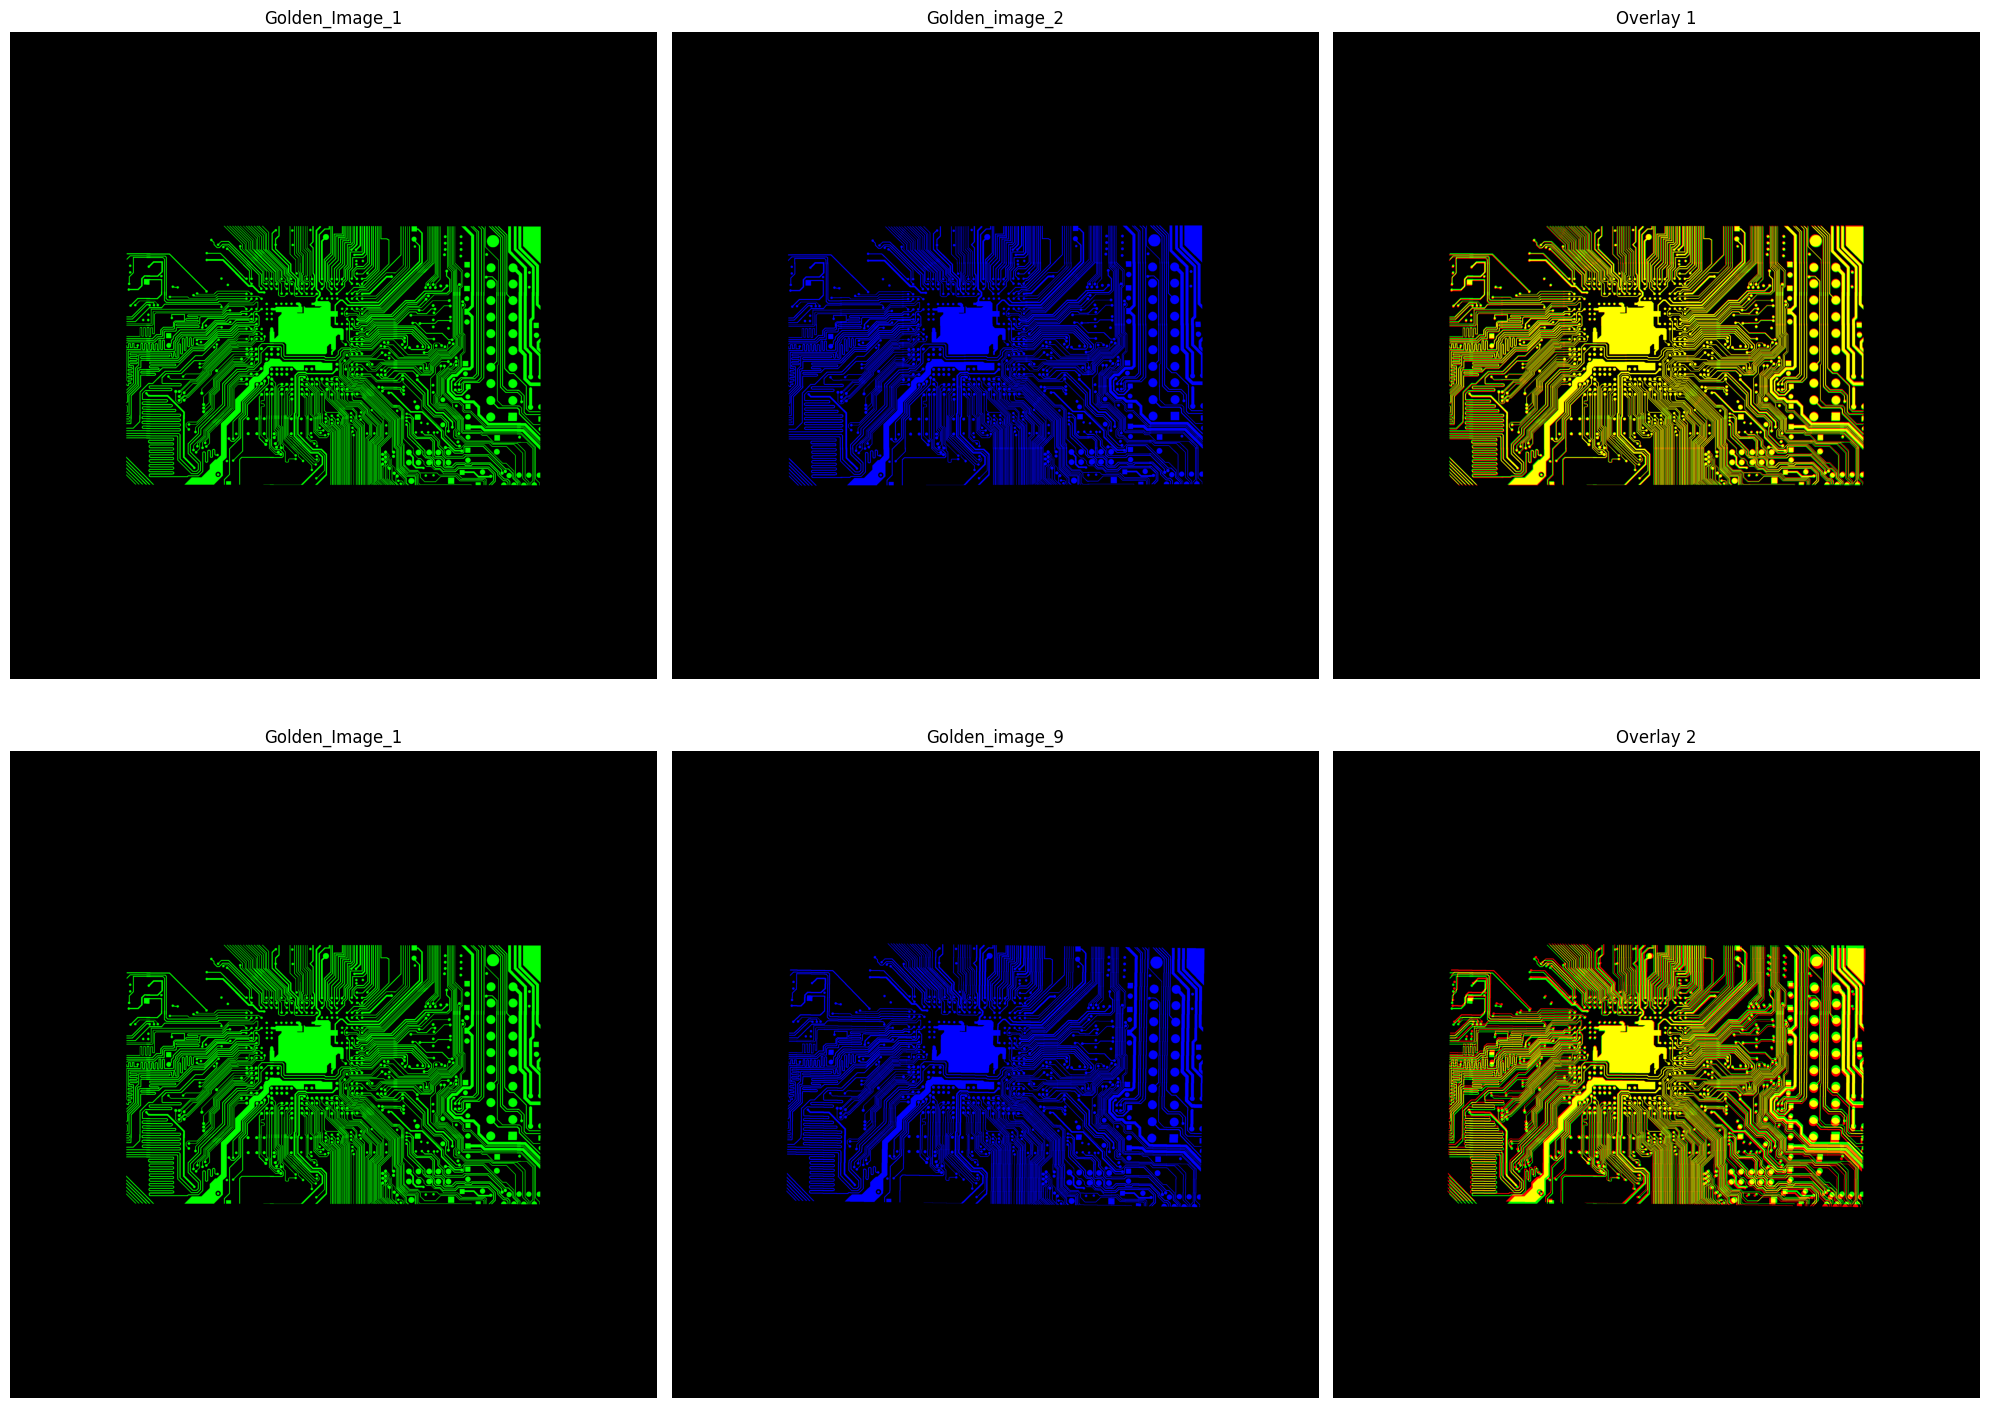

In [26]:

# Load Golden images
image1 = cv2.imread('./data/Golden images/golden_image_1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('./data/Golden images/golden_image_2.png', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('./data/Golden images/golden_image_9.png', cv2.IMREAD_GRAYSCALE)

image1 = binarize_image(image1)  #Converting images to binary
image2 = binarize_image(image2)
image3 = binarize_image(image3)

green_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
green_image[:, :, 1] = image1

blue_image = np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
blue_image[:, :, 0] = image2


blue_image3 = np.zeros((image3.shape[0], image3.shape[1], 3), dtype=np.uint8)
blue_image3[:, :, 0] = image3

# Create overlays
overlay1 = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
overlay1[:, :, 1] = image1
overlay1[:, :, 2] = image2

overlay2 = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
overlay2[:, :, 1] = image1
overlay2[:, :, 2] = image3

# Plot in a 2x3 grid
plt.figure(figsize=(20, 15))

# First row
plt.subplot(2, 3, 1)
# plt.imshow(image1, cmap='gray')
plt.imshow(cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB))
plt.title('Golden_Image_1')
plt.axis('off')

plt.subplot(2, 3, 2)
# plt.imshow(image2, cmap='gray')
plt.imshow(cv2.cvtColor(blue_image, cv2.COLOR_BGR2RGB))
plt.title('Golden_image_2')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(overlay1, cv2.COLOR_BGR2RGB))
plt.title('Overlay 1')
plt.axis('off')

# Second row
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB))
plt.title('Golden_Image_1')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(blue_image3, cv2.COLOR_BGR2RGB))
plt.title('Golden_image_9')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(overlay2, cv2.COLOR_BGR2RGB))
plt.title('Overlay 2')
plt.axis('off')

plt.tight_layout()
plt.show()

Observation: The overlaid images are in yellow, the composite colour combined of Green and Blue. This indicates that the images are similar, which means that any of the golden_images can be used as reference against the PCB_images.

Further, Overlay2 shows clearly certain distortions, suggesting that the overlaid images might differ in orientation.

The output of below cell is the mean image computed from all golden images.  Notice how the distortion is in the radially outward direction, this artifact suggests there could be *a* rotation during image acquistion.

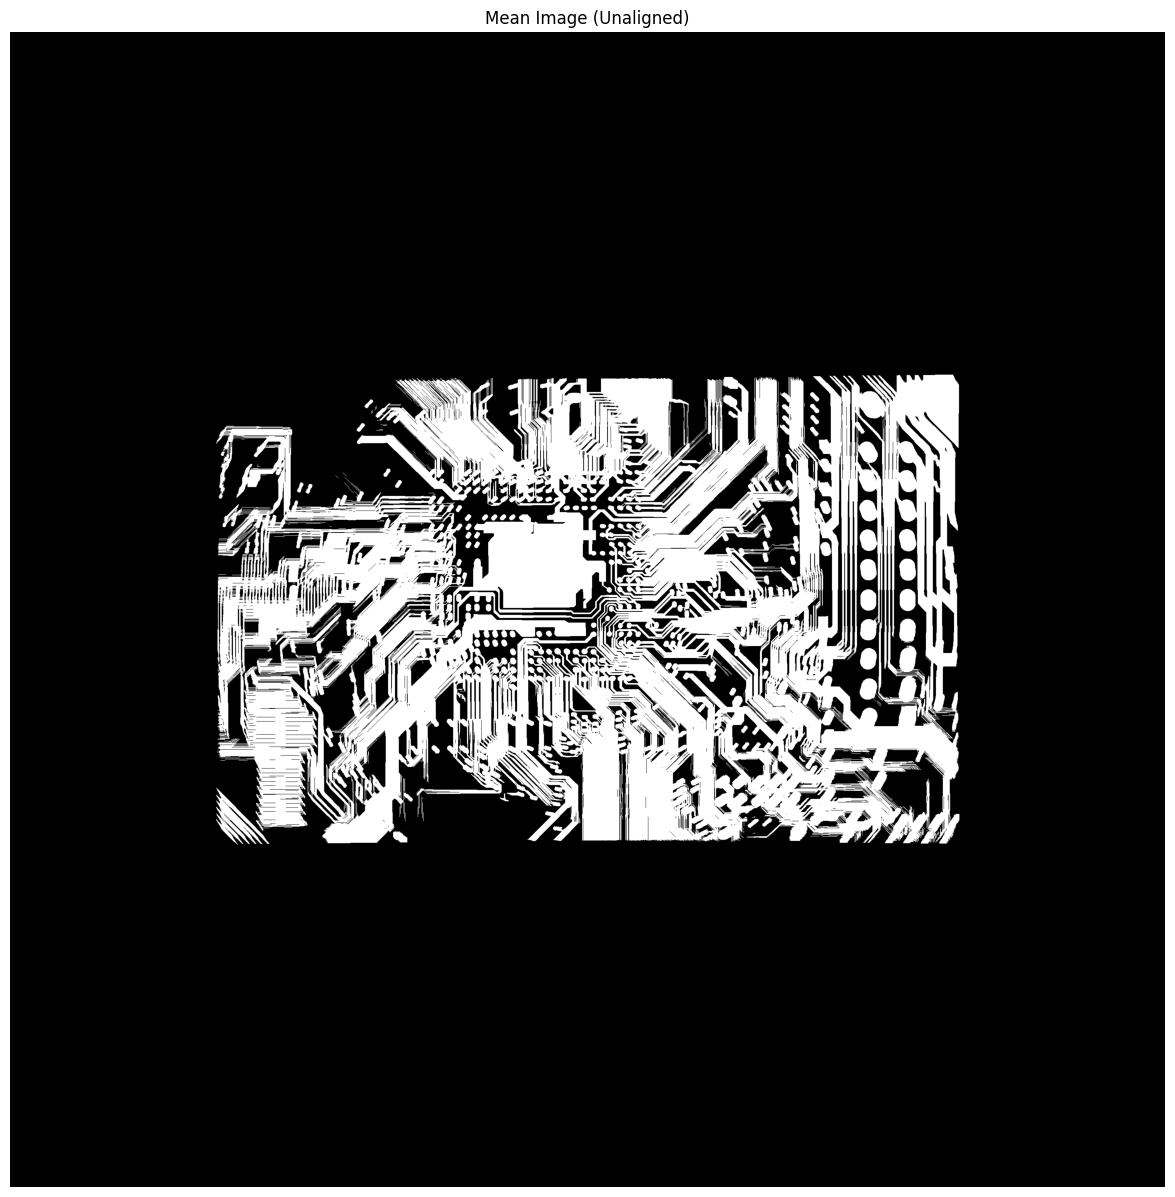

In [45]:
image_gallery = sorted(glob.glob(os.path.join("./data/Golden images", "*.png")))  # Load all images within folder
images = [binarize_image(cv2.imread(img, cv2.IMREAD_GRAYSCALE)) for img in image_gallery]
standard_image = np.mean(images, axis=0).astype(np.uint8)  # Compute mean image
plt.figure(figsize=(20, 15))
plt.imshow(binarize_image(standard_image), cmap='gray')
plt.title('Mean Image (Unaligned)')
plt.axis('off')
plt.show()

## Step 2: Image registration and alignment

Owing to the limited amount of data available, we do not use any deep learning technique. We shall stick to simple image processing methods. Having established that all golden images are just rotated copies of one another, we should align them along a common frame.

 To do so, we evaluate 2 common matching algorithms: SIFT and ORB

## Evaluate Algorithms for Image Matching

In [108]:
def align_SIFT_images(reference_image_path, image_folder, output_folder=None):
    """Align images in folder to reference image."""
    reference_image = cv2.imread(reference_image_path, cv2.IMREAD_GRAYSCALE)

    if reference_image is None:
        raise ValueError(f"Reference image not found at {reference_image_path}")
    reference_image = binarize_image(reference_image)

    image_paths = sorted(glob.glob(os.path.join(image_folder, "*.png")))
    if not image_paths:
        raise ValueError("No images found in the specified folder!")

    if output_folder and os.path.exists(output_folder):
        print("Output folder already exists. Skipping alignment.")
        return None

    detector = cv2.SIFT_create()
    aligned_images = []
    for i, path in enumerate(image_paths):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Unable to read image {path}. Skipping.")
            continue

        binary_image = binarize_image(image)
        kp_img, des_img = detector.detectAndCompute(binary_image, None)
        kp_ref, des_ref = detector.detectAndCompute(reference_image, None)

        matcher = cv2.FlannBasedMatcher()
        matches = matcher.knnMatch(des_ref, des_img, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        if len(good_matches) > 10:
            src_pts = np.float32([kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            h, w = reference_image.shape
            aligned_image = cv2.warpPerspective(binary_image, M, (w, h))
            aligned_images.append(aligned_image)

            if output_folder:
                os.makedirs(output_folder, exist_ok=True)
                output_path = os.path.join(output_folder, f"aligned_image_{i + 1}.png")
                cv2.imwrite(output_path, aligned_image)
        else:
            print(f"Warning: Not enough matches found for image {path}. Skipping alignment.")

    return aligned_images



In [109]:
def compute_standard_image(image_folder):
    """Compute binary standard image from folder of images."""
    image_paths = sorted(glob.glob(os.path.join(image_folder, "*.png")))
    if not image_paths:
        raise ValueError("No images found in the specified folder!")

    binary_images = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Unable to read image {path}. Skipping.")
            continue
        binary_images.append(binarize_image(image))

    standard_image = np.mean(binary_images, axis=0).astype(np.uint8)
    _, binary_standard_image = cv2.threshold(standard_image, 0, 255, cv2.THRESH_OTSU)
    return binary_standard_image

def plot_image(image, title="Image", cmap='gray'):
    """Plot image using matplotlib."""
    plt.figure(figsize=(20, 15))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()



Output folder already exists. Skipping alignment.


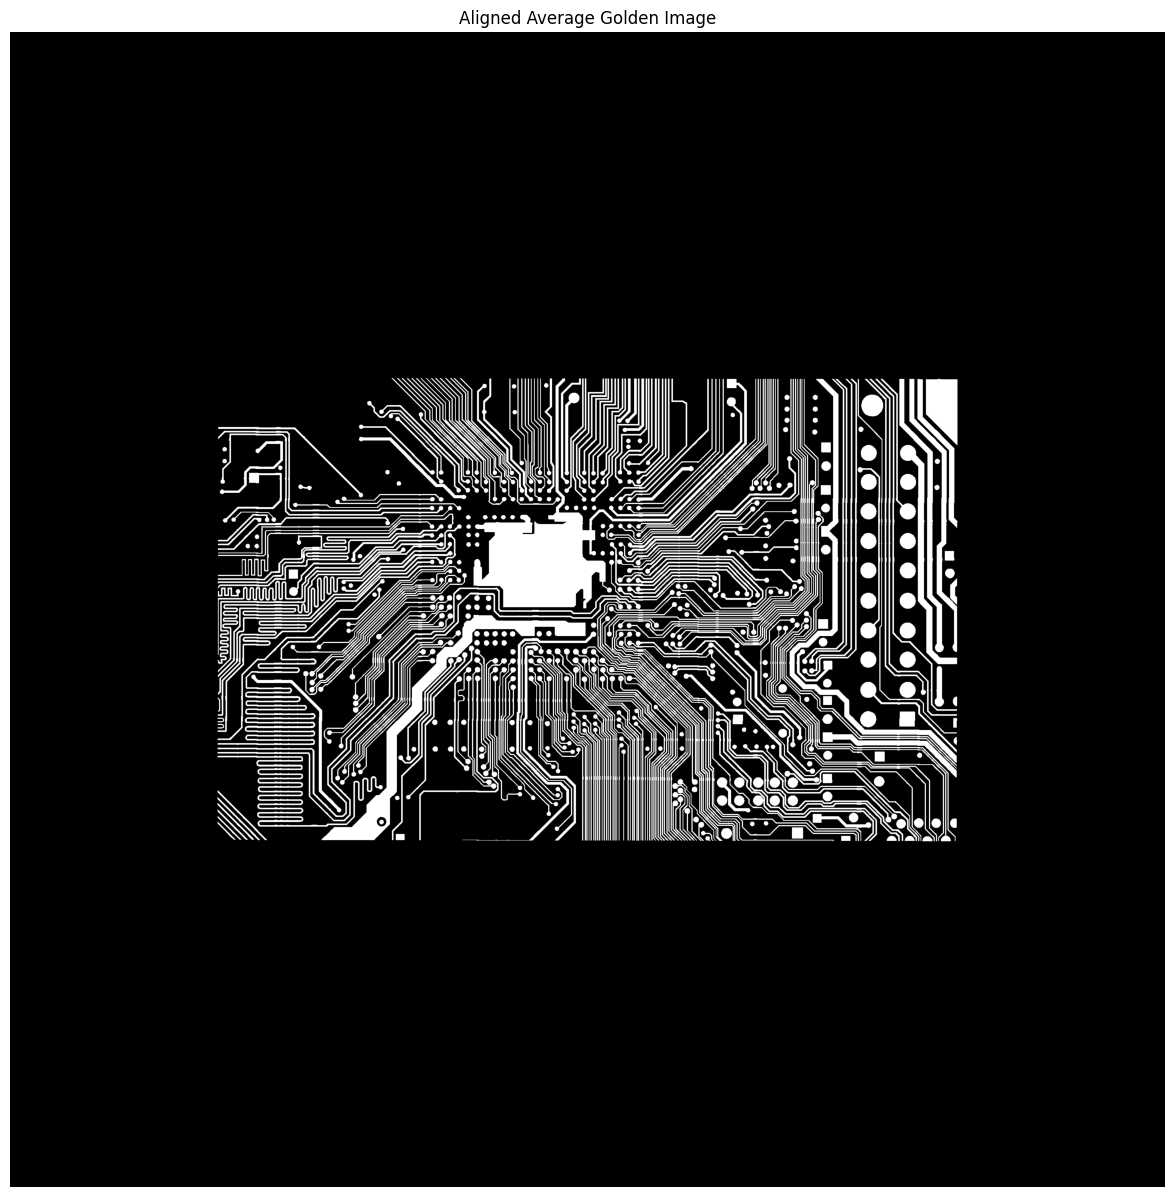

In [110]:
reference_image_path = "./data/Golden images/golden_image_1.png"
image_folder = "./data/Golden images"
output_folder = "./data/golden_aligned_ref1"

aligned_images = align_SIFT_images(reference_image_path, image_folder, output_folder)
golden_template_SIFT_aligned = compute_standard_image(output_folder)
plot_image(golden_template_SIFT_aligned, title="Aligned Average Golden Image")

In [112]:
def align_binary_images(reference_image, image_folder, output_folder=None):
    """
    Align binary images to a reference binary image.
    """
    binary_reference = binarize_image(reference_image)

    detector = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    aligned_images = []
    for i, path in enumerate(sorted(glob.glob(os.path.join(image_folder, "*.png")))):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Unable to read image {path}. Skipping.")
            continue

        binary_image = binarize_image(image)

        kp_img, desc_img = detector.detectAndCompute(binary_image, None)
        kp_ref, desc_ref = detector.detectAndCompute(binary_reference, None)

        matches = matcher.match(desc_ref, desc_img)

        if len(matches) > 10:
            src_pts = np.float32([kp_ref[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_img[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            h, w = binary_reference.shape
            aligned_image = cv2.warpPerspective(binary_image, M, (w, h))
            aligned_images.append(aligned_image)

            if output_folder:
                os.makedirs(output_folder, exist_ok=True)
                output_path = os.path.join(output_folder, f"aligned_image_{i + 1}.png")
                cv2.imwrite(output_path, aligned_image)
        else:
            print(f"Warning: Not enough matches found for image {path}. Skipping alignment.")

    return aligned_images

# Example usage
reference_image = cv2.imread("./data/Golden images/golden_image_1.png", cv2.IMREAD_GRAYSCALE)
aligned_images = align_binary_images(reference_image, "./data/Golden images", output_folder="./data/golden_aligned_ORB")

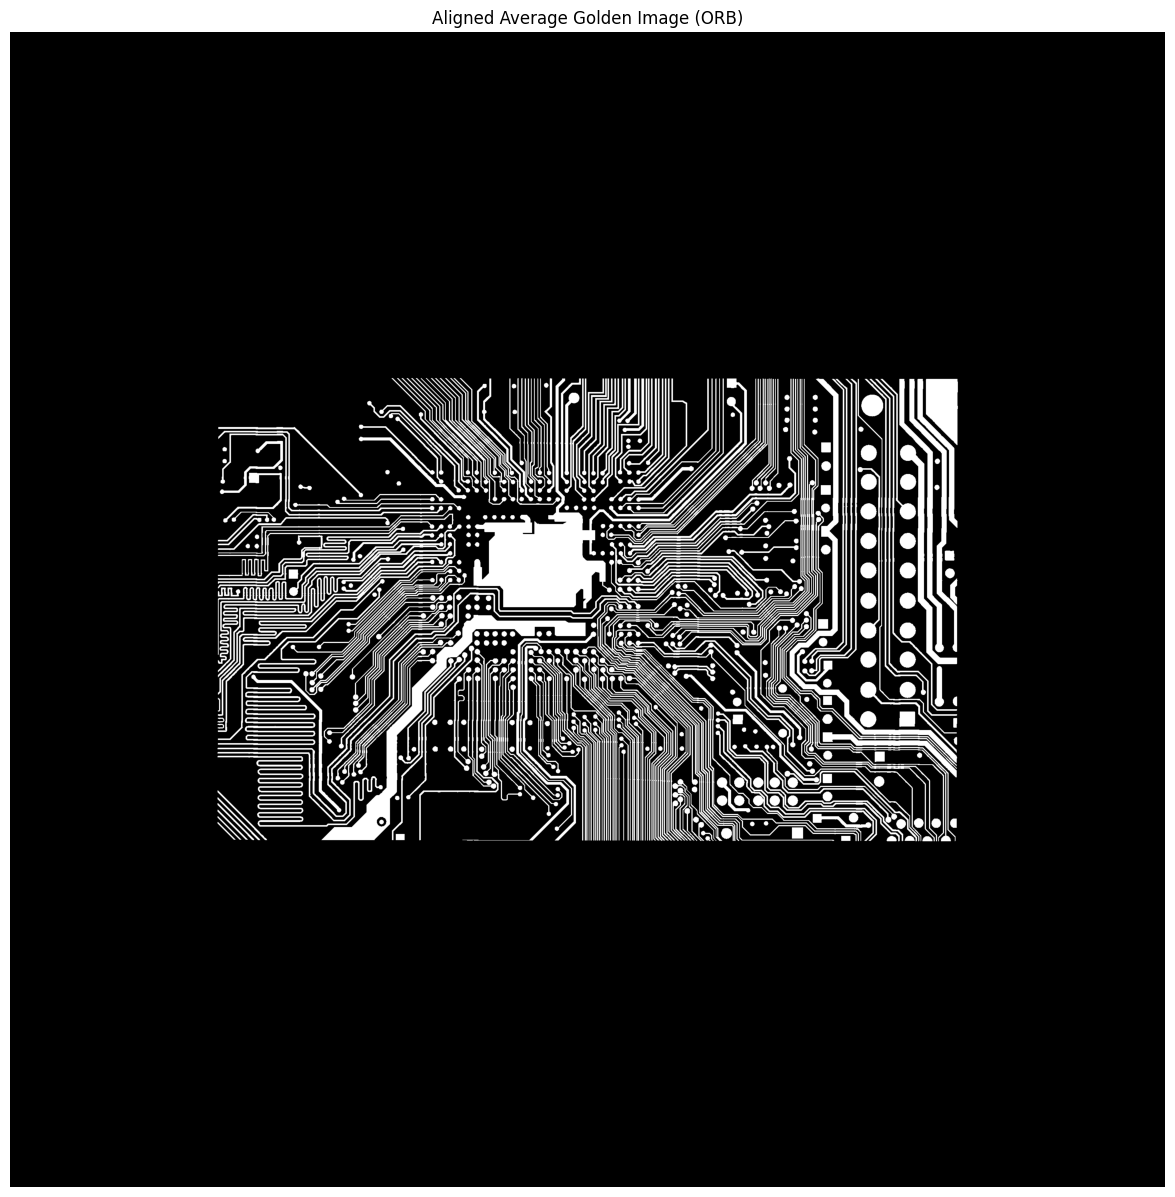

In [113]:
output_folder="./data/golden_aligned_ORB"
if aligned_images is not None:
    golden_template_ORB_aligned = compute_standard_image(output_folder)
    plot_image(golden_template_ORB_aligned, title="Aligned Average Golden Image (ORB)")

Let's assess the accuracy of these matching algorithms. We do so by a common error  metric in Machine learning : Mean Squared Error.

In [175]:
'''Helper function to assess accuracy of matching algorithms'''

def mean_squared_error(image1, image2):
    return np.mean((image1 - image2) ** 2)

def compute_mse_for_folder(reference_image, aligned_folder):

    mse_values = []
    for path in sorted(glob.glob(os.path.join(aligned_folder, "*.png"))):
        aligned_image = binarize_image(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
        if aligned_image is None:
            print(f"Warning: Unable to read image {path}. Skipping.")
            continue
        mse = mean_squared_error(reference_image, aligned_image)
        mse_values.append(mse)
    return np.mean(mse_values)

In [176]:
reference_image = cv2.imread("./data/Golden images/golden_image_1.png", cv2.IMREAD_GRAYSCALE)

aligned_folder_1 = "./data/golden_aligned_ref1"  # Aligned using SIFT
aligned_folder_2 = "./data/golden_aligned_ORB"
avg_mse_1 = compute_mse_for_folder(reference_image, aligned_folder_1) # Compute MSE for each folder
avg_mse_2 = compute_mse_for_folder(reference_image, aligned_folder_2)

print("Algorithm 1 - Average MSE:", avg_mse_1)
print("Algorithm 2 - Average MSE:", avg_mse_2)

Algorithm 1 - Average MSE: 3.0330959111111113
Algorithm 2 - Average MSE: 3.0616932666666665


The difference is negligible between these matching algorithms. However, while generation of aligned_images, ORB generated the aligned images quicker.
We proceed with ORB below.



### Image Subtraction and anomaly detection
In this pipeline, we work with grayscale images to retain as much information as possible. We load 1 original image and 1 defective image of each type.

1.   The defective image is aligned to the original image using ORB (Oriented FAST and Rotated BRIEF) for feature detection and matching.

2. A homography matrix is computed to warp the defective image, ensuring it aligns perfectly with the original.

3.  The absolute difference between the aligned defective image and the original image is computed. This highlights regions where the two images differ.

4. Contours are detected on the thresholded difference image. These contours represent the boundaries of anomalous regions.

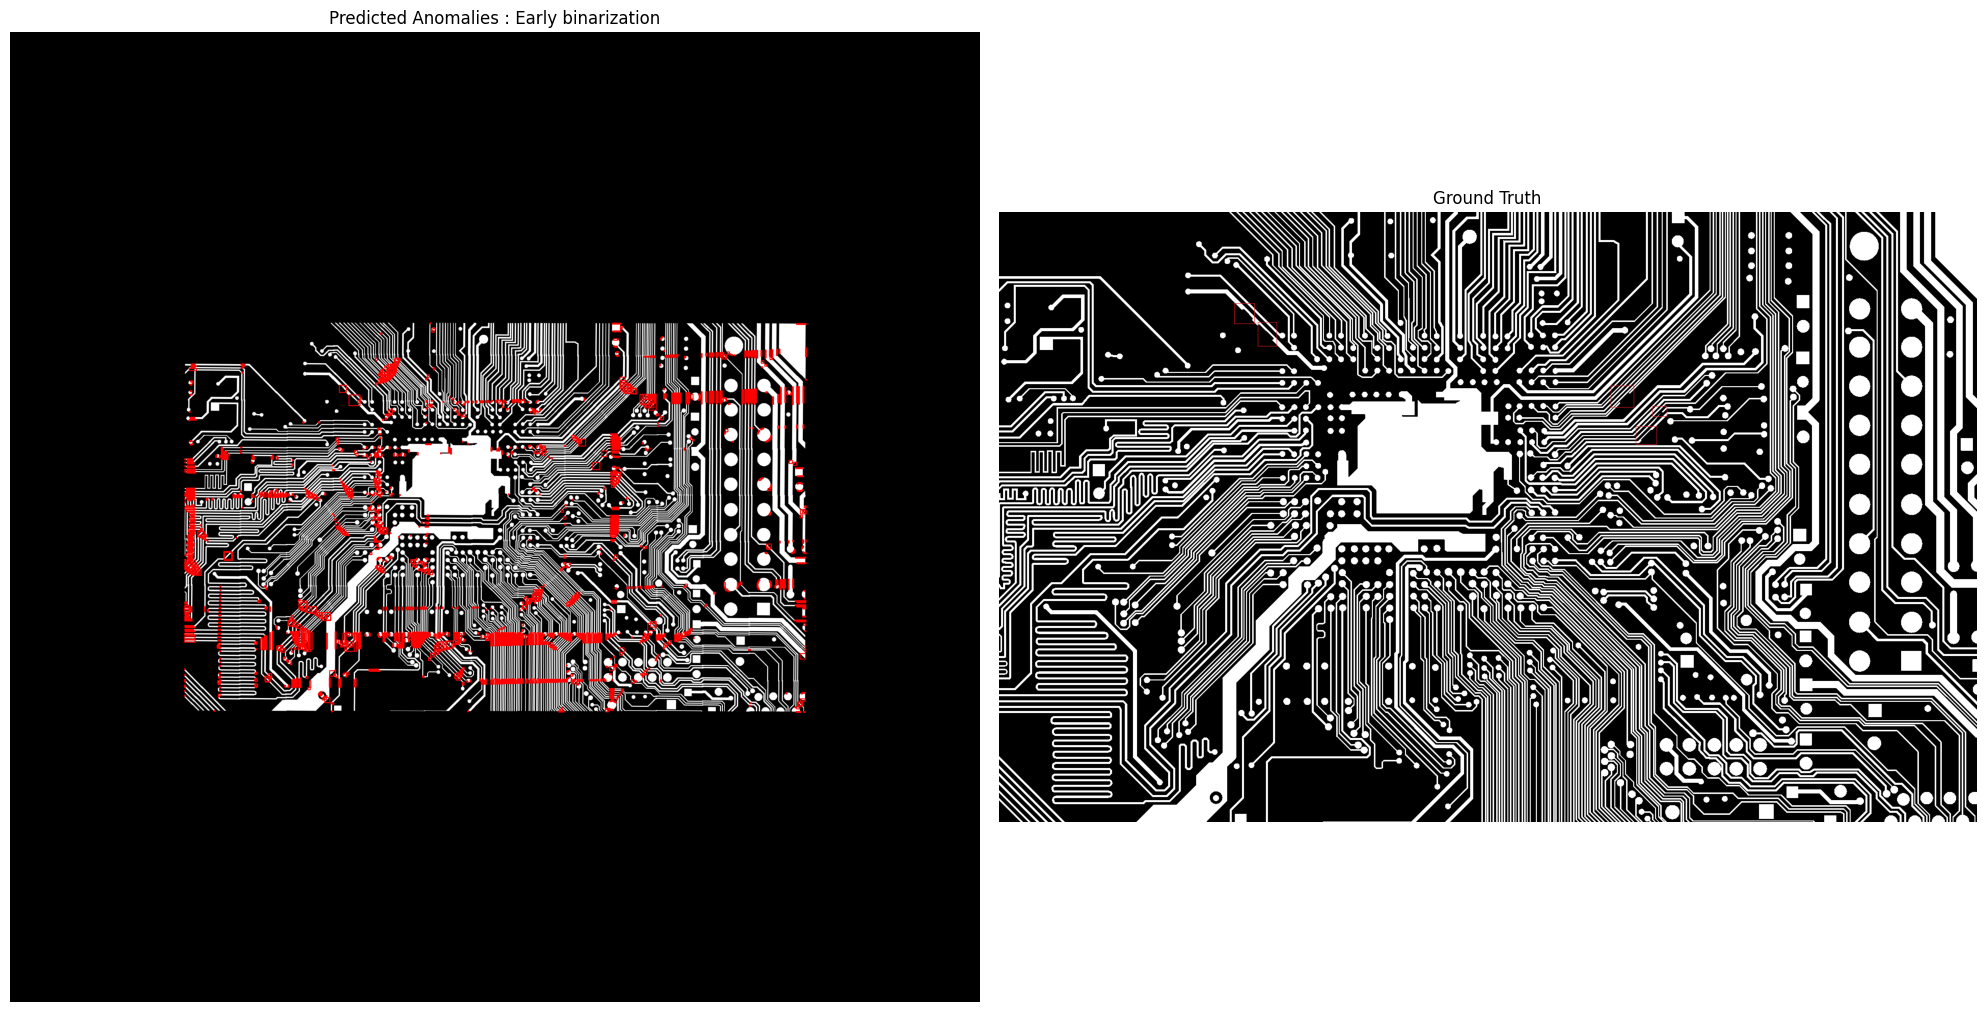

In [172]:
def detect_binarized_anomalies(golden_image_path, defective_image_path, num_matches, threshold):

    # Load and binarize the golden reference image
    golden_image = cv2.imread(golden_image_path, cv2.IMREAD_GRAYSCALE)
    golden_image = binarize_image(golden_image)
    if golden_image is None:
        raise ValueError(f"Golden reference image not found at {golden_image_path}")

    defective_image = cv2.imread(defective_image_path, cv2.IMREAD_GRAYSCALE)
    defective_image = binarize_image(defective_image)
    if defective_image is None:
        raise ValueError(f"Defective image not found at {defective_image_path}")

    detector = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Detect keypoints and descriptors
    kp_defective, desc_defective = detector.detectAndCompute(defective_image, None)
    kp_golden, desc_golden = detector.detectAndCompute(golden_image, None)

    matches = matcher.match(desc_golden, desc_defective)

    # Compute homography, receiving num_matches as argument
    if len(matches) > num_matches:
        src_pts = np.float32([kp_golden[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_defective[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        h, w = golden_image.shape
        aligned_defective = cv2.warpPerspective(defective_image, M, (w, h))
    else:
        raise ValueError("Not enough matches found for alignment.")

    difference = cv2.absdiff(golden_image, aligned_defective)

    _, thresholded_diff = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cv2.cvtColor(aligned_defective, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box for each contour
        cv2.rectangle(output_image, (x, y), (x + w+2, y + h+2), (0, 0, 255), 2)  # Draw red rectangle, with width and height of atleast 2
    return output_image


golden_image_path = "./data/Golden images/golden_image_1.png"
defective_image_path = "/content/data/pcb1_defect_images/defect_image_2_.png"

anomaly_image = detect_binarized_anomalies(golden_image_path, defective_image_path, 0, 200)
Ground_truth_pcb1 = '/content/data/pcb1_defect_highlighted/image1_highlighted.png'

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the predicted anomaly image in the first subplot
ax[0].imshow(cv2.cvtColor(anomaly_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Predicted Anomalies : Early binarization")
ax[0].axis('off')


# Load the ground truth image and display it in the second subplot
saved_image = cv2.imread(Ground_truth_pcb1)
ax[1].imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Ground Truth")
ax[1].axis('off')

plt.tight_layout()
plt.show()

Above was an example where we binarized prior to the image subtraction, which lead to a severe loss of information. It is key to retain information in grayscale, and binarize only after the difference 'heatmap' is generated. The below approaches follow this path.

In [168]:
def detect_anomalies(golden_image_path, defective_image_path, num_matches, threshold):
    golden_image = cv2.imread(golden_image_path, cv2.IMREAD_GRAYSCALE) # Retain grayscale info
    if golden_image is None:
        raise ValueError(f"Golden reference image not found at {golden_image_path}")

    defective_image = cv2.imread(defective_image_path, cv2.IMREAD_GRAYSCALE) # Retain grayscale info
    if defective_image is None:
        raise ValueError(f"Defective image not found at {defective_image_path}")

    detector = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Detect keypoints and descriptors
    kp_defective, desc_defective = detector.detectAndCompute(defective_image, None)
    kp_golden, desc_golden = detector.detectAndCompute(golden_image, None)

    matches = matcher.match(desc_golden, desc_defective)

    # Compute homography if enough matches are found
    if len(matches) > num_matches:
        src_pts = np.float32([kp_golden[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_defective[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        h, w = golden_image.shape
        aligned_defective = cv2.warpPerspective(defective_image, M, (w, h))
    else:
        raise ValueError("Not enough matches found for alignment.")

    difference = cv2.absdiff(golden_image, aligned_defective)

    _, thresholded_diff = cv2.threshold(difference, threshold, 255, cv2.THRESH_BINARY) # Applying binary thresh only on resultant output.

    contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cv2.cvtColor(aligned_defective, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box for each contour
        cv2.rectangle(output_image, (x, y), (x + w+5, y + h+5), (0, 0, 255), 2)  # Draw red rectangle
    return output_image


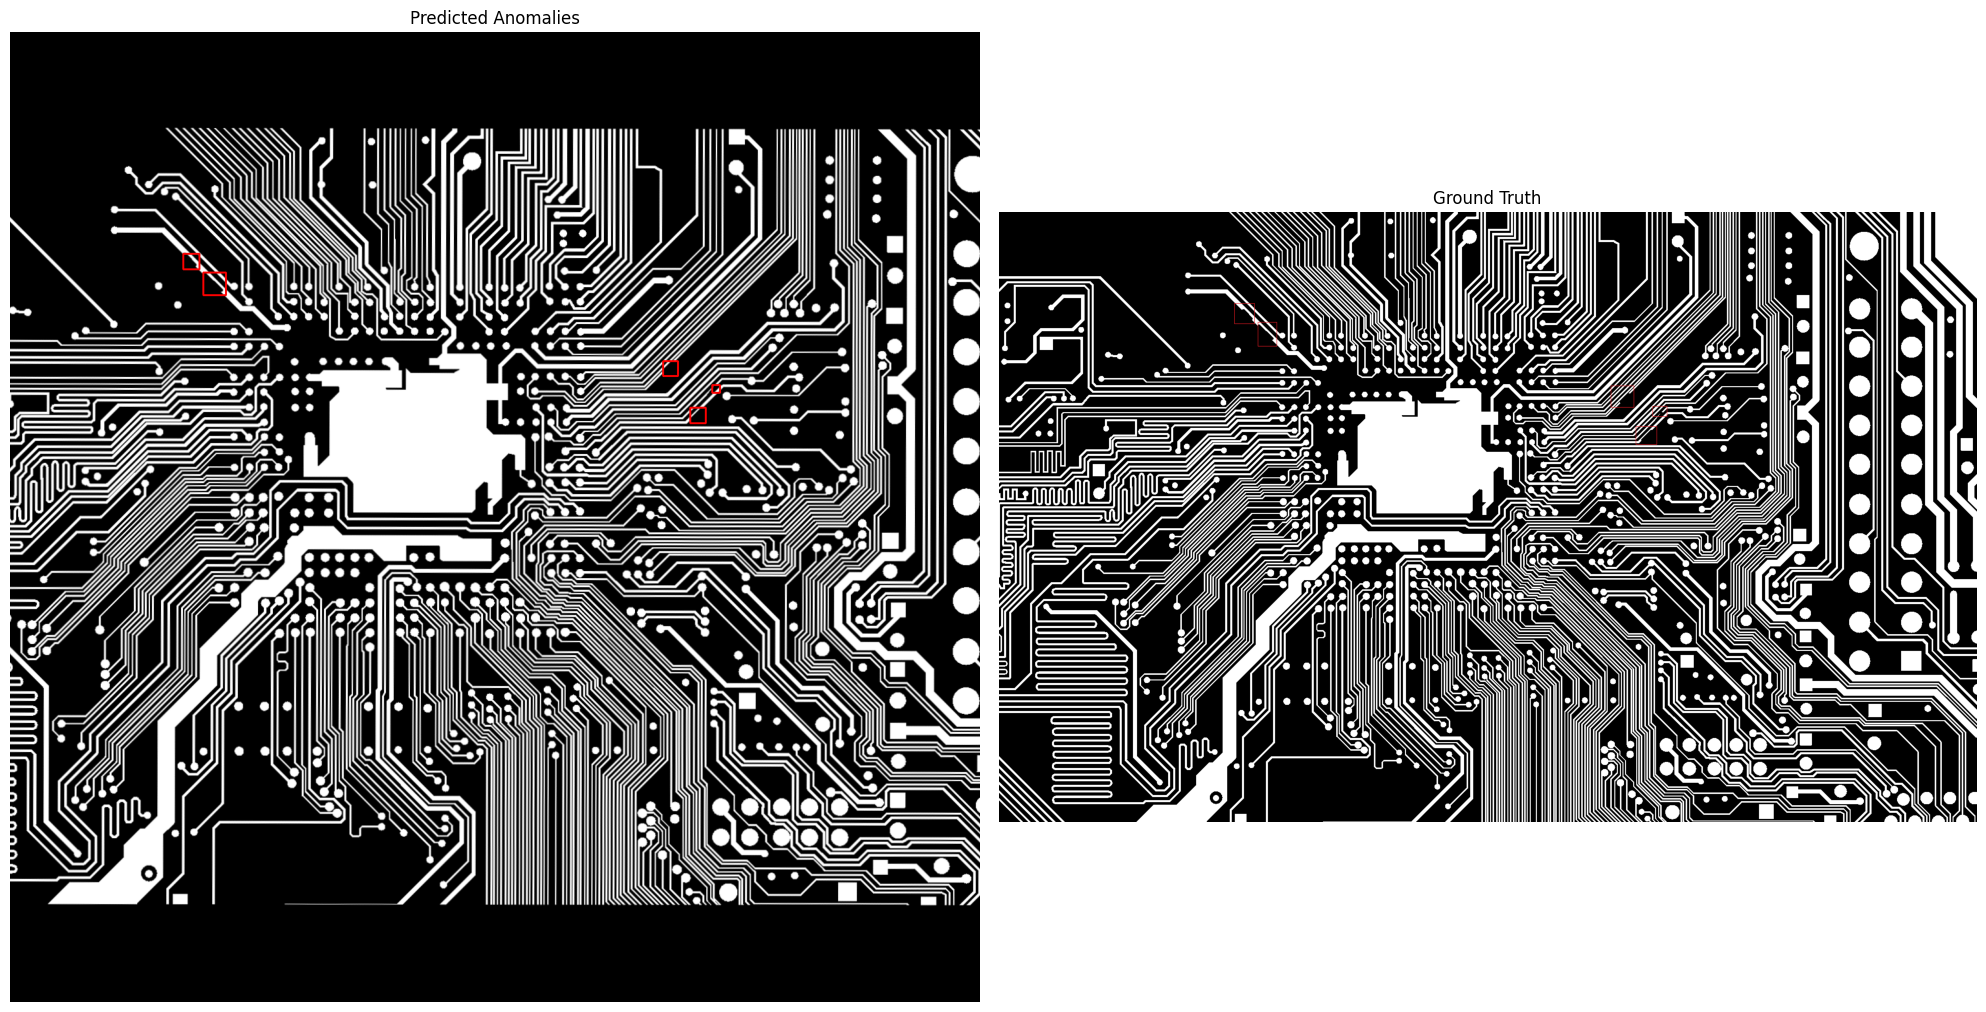

In [178]:
golden_image_path = "./data/Golden images/golden_image_1.png"
defective_image_path = "/content/data/pcb1_defect_images/defect_image_2_.png"

anomaly_image = detect_anomalies(golden_image_path, defective_image_path, 50, 200)
Ground_truth_pcb1 = '/content/data/pcb1_defect_highlighted/image1_highlighted.png'

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(anomaly_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Predicted Anomalies")
ax[0].axis('off')

#Zoomed in .. hard to see
height, width, _ = anomaly_image.shape
zoom_factor = 2
ax[0].set_xlim(width // 4, 3 * width // 4)
ax[0].set_ylim(3 * height // 4, height // 4)


saved_image = cv2.imread(Ground_truth_pcb1)
ax[1].imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Ground Truth")
ax[1].axis('off')

plt.tight_layout()
plt.show()

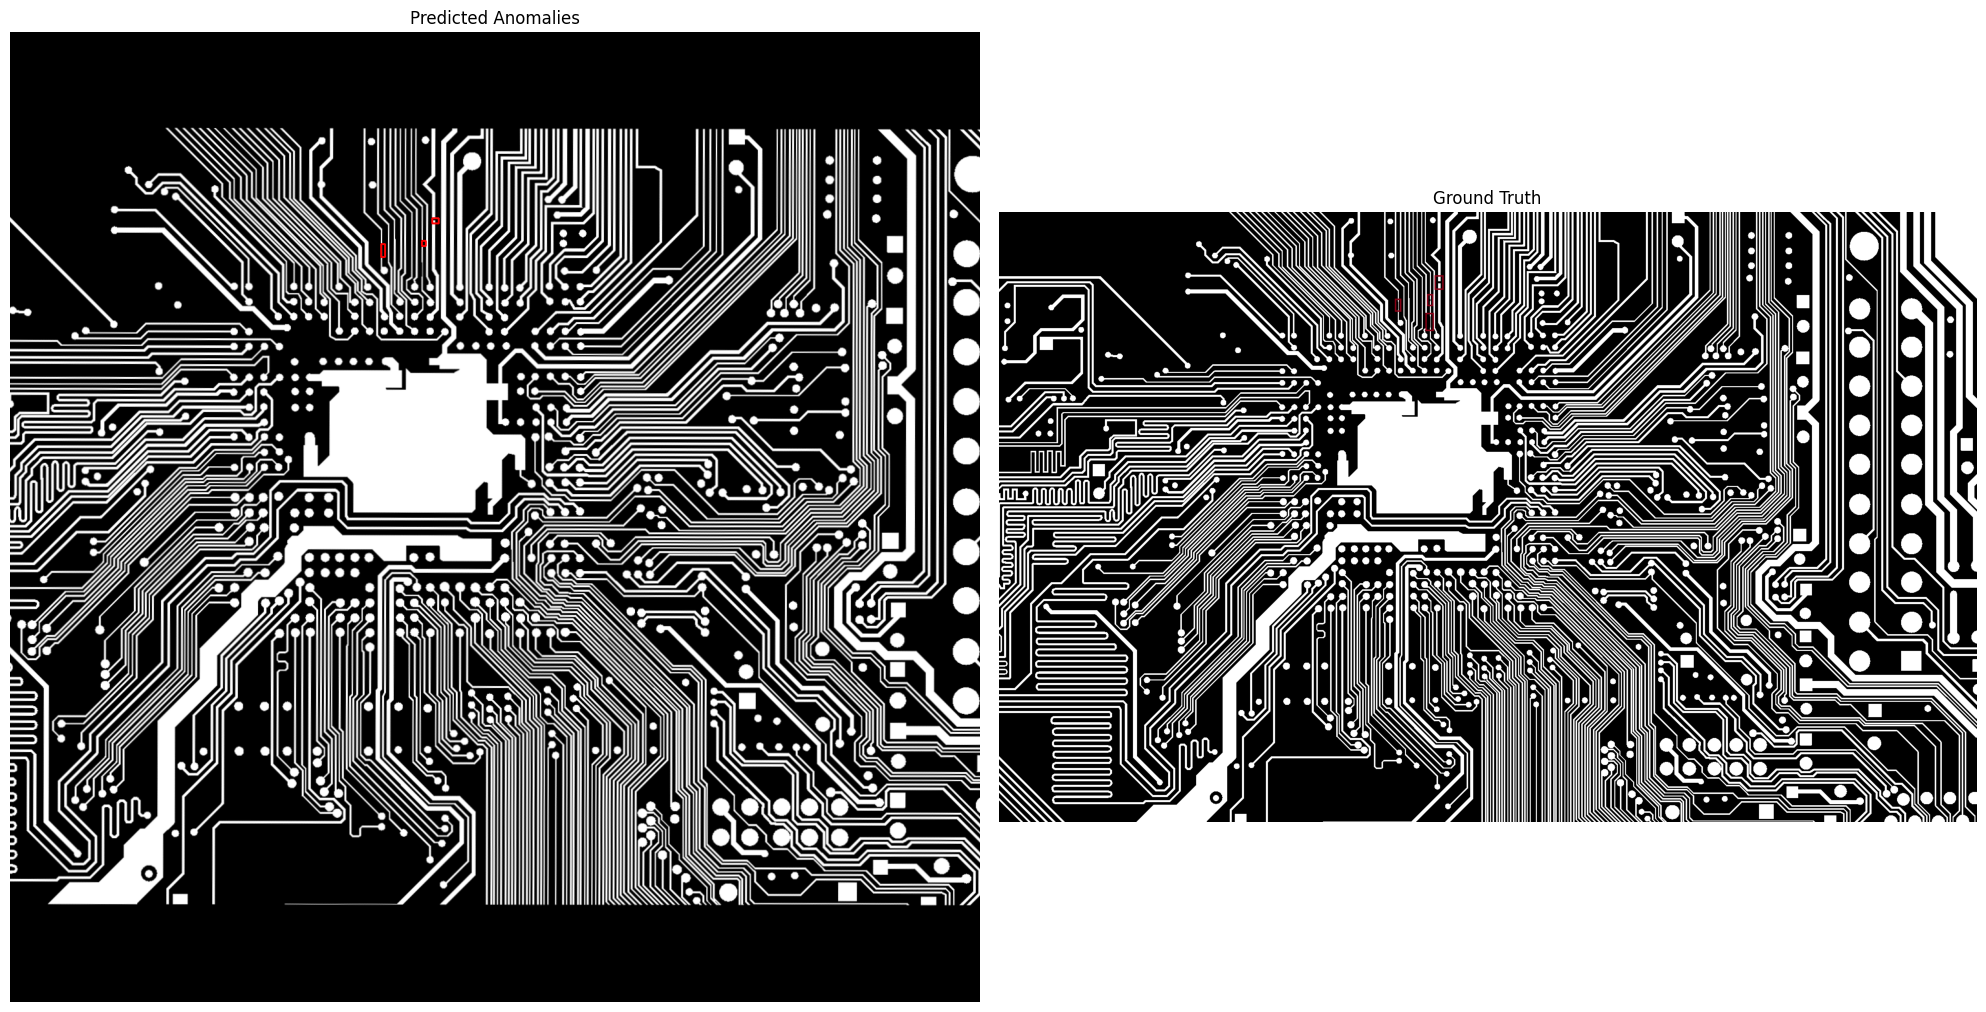

In [183]:
golden_image_path = "./data/Golden images/golden_image_1.png"
defective_image_path = "/content/data/pcb2_defect_images/defect_image_2_.png"
anomaly_image = detect_anomalies(golden_image_path, defective_image_path, 50, 200)
Ground_truth_pcb2 = '/content/data/pcb2_defect_highlighted/image2_highlited.png'

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(anomaly_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Predicted Anomalies")
ax[0].axis('off')

height, width, _ = anomaly_image.shape
zoom_factor = 2
ax[0].set_xlim(width // 4, 3 * width // 4)
ax[0].set_ylim(3 * height // 4, height // 4)

saved_image = cv2.imread(Ground_truth_pcb2)
ax[1].imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Ground Truth")
ax[1].axis('off')


plt.tight_layout()
plt.show()

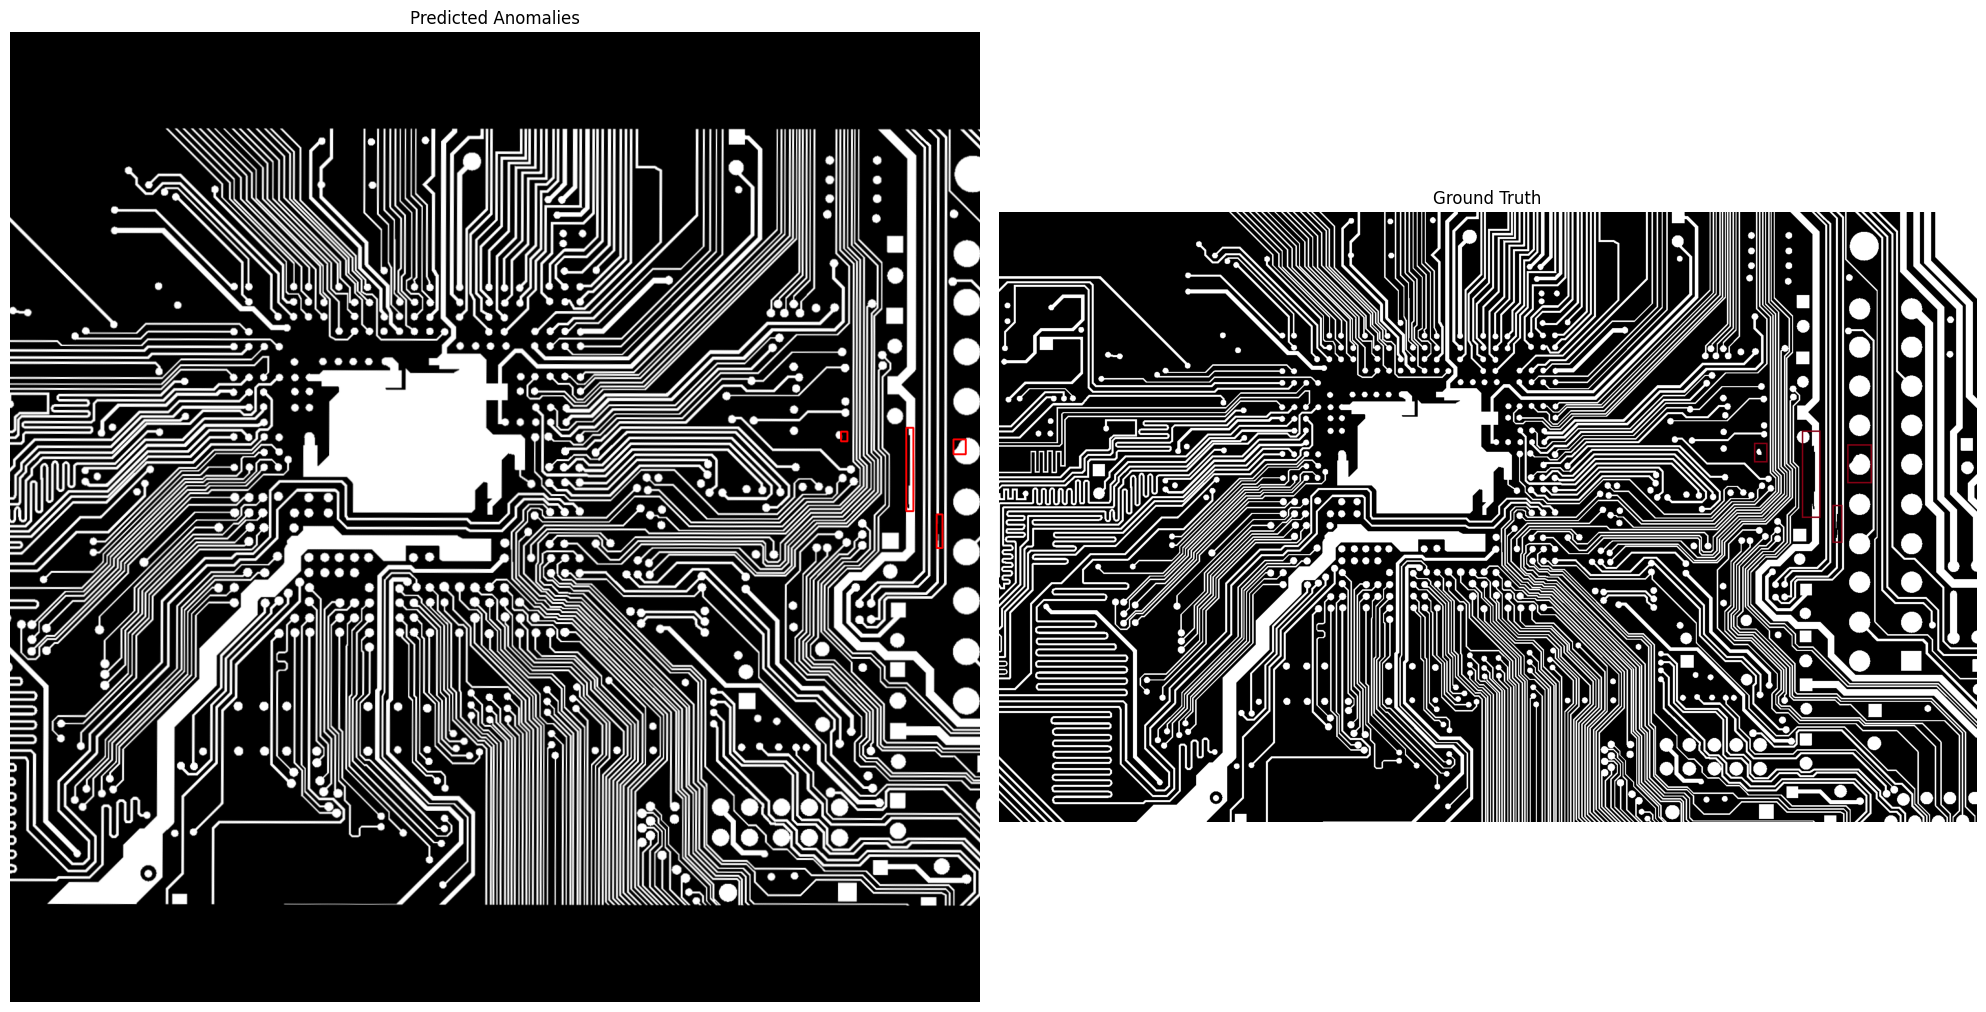

In [171]:
golden_image_path = "./data/Golden images/golden_image_1.png"
defective_image_path = "/content/data/pcb3_defect_images/defect_image_3_.png"

anomaly_image = detect_anomalies(golden_image_path, defective_image_path, 50, 200)
Ground_truth_pcb2 = '/content/data/pcb3_defect_highlighted/image3_highlited.png'

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(anomaly_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Predicted Anomalies")
ax[0].axis('off')


height, width, _ = anomaly_image.shape
zoom_factor = 2
ax[0].set_xlim(width // 4, 3 * width // 4)
ax[0].set_ylim(3 * height // 4, height // 4)
saved_image = cv2.imread(Ground_truth_pcb2)
ax[1].imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Ground Truth")
ax[1].axis('off')

plt.tight_layout()
plt.show()

Limitations:  

1.  Sensitive to Binarization
2.  Sensitive to Thresholding
3.  Works only with a reference image
